# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

---
## Step 0: Load the Data

In [1]:
# Load pickled data
import pickle
from sklearn.model_selection import train_test_split

# TODO: Fill this in based on where you saved the training and testing data
training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style("whitegrid", {'axes.grid' : False})

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = y_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes_tr, n_classes_count_tr = np.unique(y_train, return_counts=True)
n_classes_te, n_classes_count_te = np.unique(y_test,  return_counts=True)

print("Total number of examples =", n_train+n_test)
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", len(n_classes_tr))

Total number of examples = 51839
Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

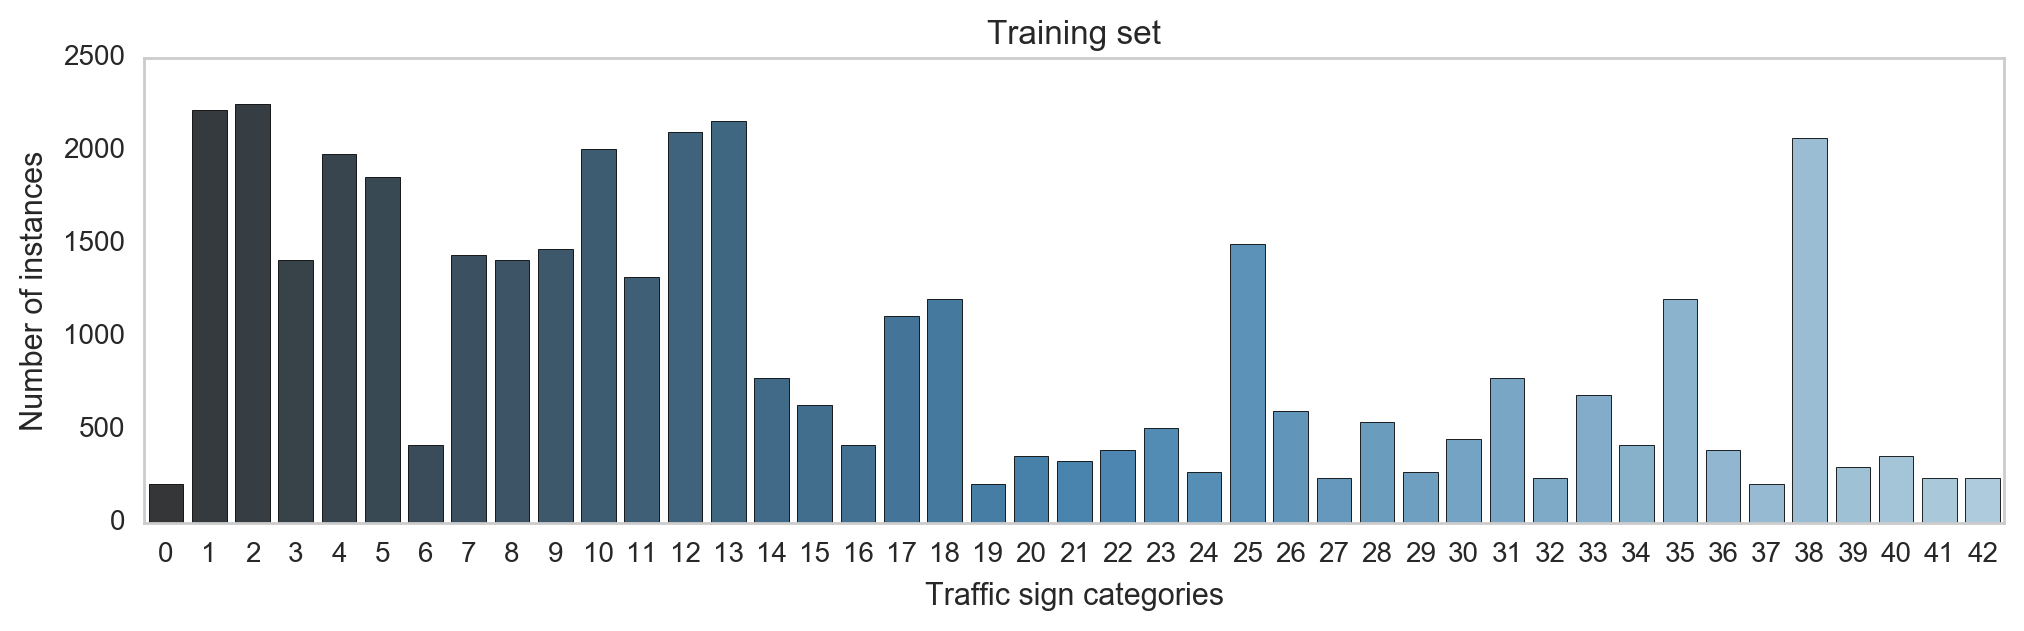

In [3]:
# counts for each category in the training set before data augmentation

fig, ax = plt.subplots(figsize=(12,3))
sns.barplot(n_classes_tr, n_classes_count_tr, palette="Blues_d")
ax.set(xlabel="Traffic sign categories", ylabel="Number of instances", title="Training set");

Average ratio: 31.2%


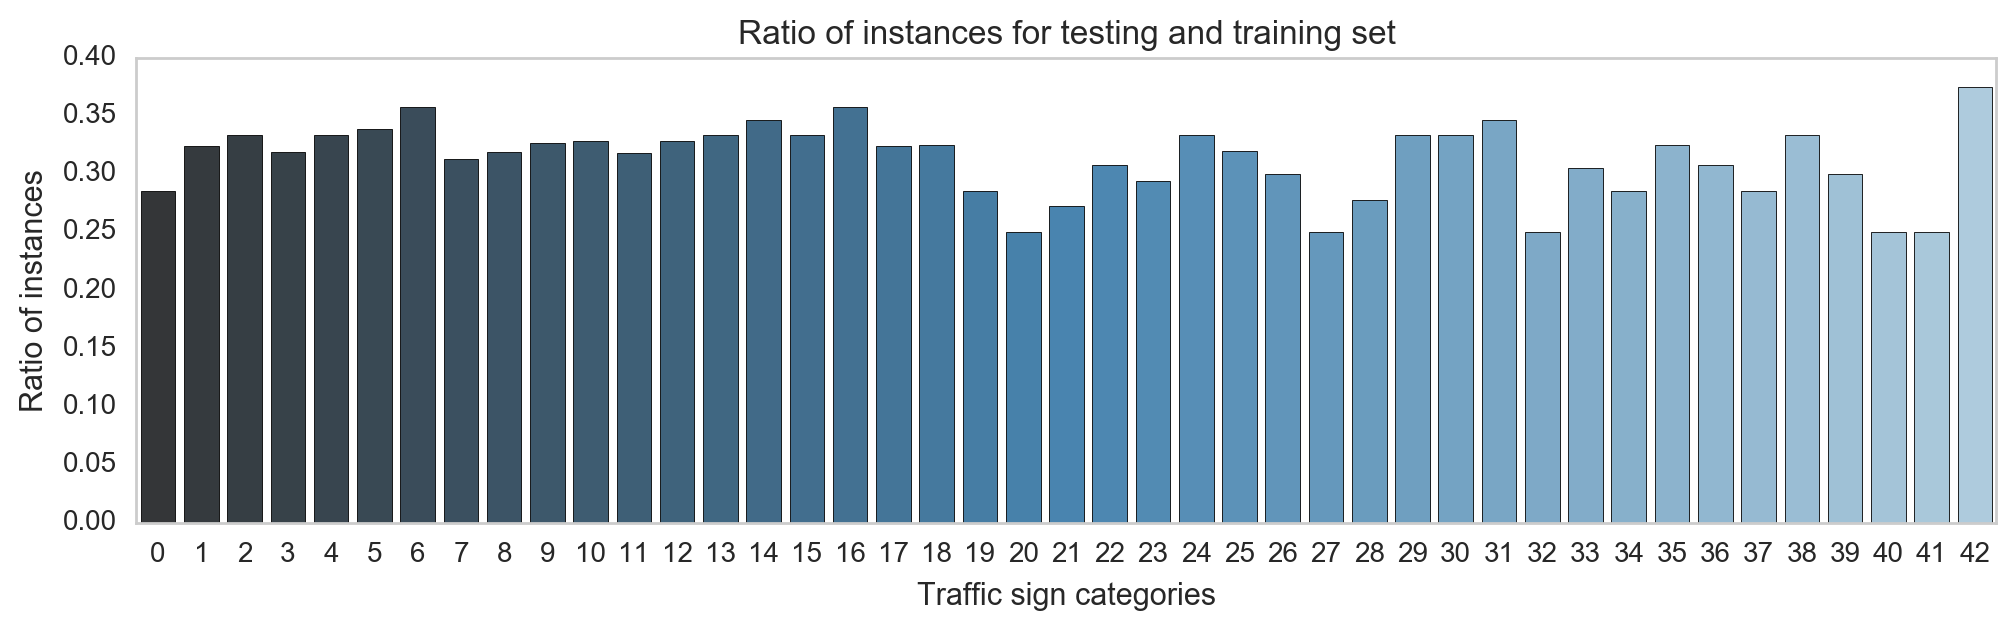

In [4]:
# Ratio of the number of testing samples vs training samples for each category 

fig, ax = plt.subplots(figsize=(12,3))
sns.barplot(n_classes_te, n_classes_count_te/n_classes_count_tr, palette="Blues_d")
ax.set(xlabel="Traffic sign categories", ylabel="Ratio of instances", title="Ratio of instances for testing and training set")
print("Average ratio: {:4.3}%".format(np.mean(n_classes_count_te/n_classes_count_tr*100)))

In [5]:
df_csv = pd.read_csv("signnames.csv")
df_csv.SignName

0                                  Speed limit (20km/h)
1                                  Speed limit (30km/h)
2                                  Speed limit (50km/h)
3                                  Speed limit (60km/h)
4                                  Speed limit (70km/h)
5                                  Speed limit (80km/h)
6                           End of speed limit (80km/h)
7                                 Speed limit (100km/h)
8                                 Speed limit (120km/h)
9                                            No passing
10         No passing for vehicles over 3.5 metric tons
11                Right-of-way at the next intersection
12                                        Priority road
13                                                Yield
14                                                 Stop
15                                          No vehicles
16             Vehicles over 3.5 metric tons prohibited
17                                             N

---
## Step 2: Preprocessing and Data Augmentation

Preprocessing pipeline:
original img (RGB) ->  img (LAB) -> adaptive equalization on the L channel -> img (RGB) 
                   ->  standardized img (RGB) during batch preprocessing
                   
Data augmentation pipeline:
img (RGB) -> rand. rotation -> rand. translation -> rand. shear -> transformed img(RGB)
the matching label of the transformed img is simply copied from the original img


In [6]:
def preprocess_single(img):
    '''Return a single image processed with brightness equalization. 
    
    The input img is first converted from RBG to LAB, then adaptive equalization is applied on the L channel.
    The resulting img is converted back to RGB space for display
    
    '''
    clahe = cv2.createCLAHE(clipLimit=10, tileGridSize=(3,3))
    
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    img_lab[:,:,0] = clahe.apply(img_lab[:,:,0])
    img_rgb = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)

    return img_rgb

def preprocess_batch(batch_x, batch_y):
    '''Return batch processed and standardized images

       batch_x is of dim (num_of_samples, width, height, color_channel)
    '''  
    
    batch_x_norm = np.zeros_like(batch_x, dtype="float32")   
    for idx, img in enumerate(batch_x):
        img = preprocess_single(img)
        batch_x_norm[idx, :, :, :] = (img.astype("float32")-128.0) / 255

    return batch_x_norm, batch_y

def class_indices(input_array):
    """Return a list of indices for each class (modified from https://goo.gl/abAOe6)"""
    
    vals, inverse, counts = np.unique(input_array, return_inverse=True, return_counts=True)
    rows, cols            = np.where (inverse == vals[:, np.newaxis])
    _   , inverse_rows    = np.unique(rows, return_index=True)

    return np.split(cols, inverse_rows[1:])

def augment_image_single(img, ang_range=15,shear_range=8,trans_range=4):
    '''Return an img with random rotation, translation and shear
    
    Modified from Yivek Yadav's approach using OpenCV (https://goo.gl/ttRKL0)
    '''
    img_aug = np.copy(img)
    
    # rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    height,width,ch = img_aug.shape    
    rot_M = cv2.getRotationMatrix2D((width/2,height/2),ang_rot,1)

    # translation
    tr_x, tr_y = trans_range*np.random.uniform(size=(2,1))-trans_range/2
    trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1  = 5+shear_range*np.random.uniform()-shear_range/2
    pt2  = 20+shear_range*np.random.uniform()-shear_range/2
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img_aug = cv2.warpAffine(img_aug,rot_M,(width,height))
    img_aug = cv2.warpAffine(img_aug,trans_M,(width,height))
    img_aug = cv2.warpAffine(img_aug,shear_M,(width,height))

    return img_aug.reshape(-1, *img_aug.shape)

def augment_images(X_data, y_data, multiplier=1.5):
    ''' return an augmented image dataset with same number of samples in each category
    
    '''
    
    X_data_augs = [X_data]
    y_data_augs = [y_data]
    
    class_indices_list = class_indices(y_data)
    class_labels, class_counts = np.unique(y_data, return_counts=True)
    
    n_target = np.int(multiplier*np.max(class_counts))
    n_augs = [n_target - class_count for class_count in class_counts]
    
    print("Target num of samples for each class: {}".format(n_target))
    print("Total num of training samples: {}\n".format(n_target*len(class_labels)))
    for class_label, n_aug, class_indices_data in zip(class_labels, n_augs, class_indices_list):    
        
        print("Augmenting class: {:2} with {:4} samples".format(class_label, n_aug))
        for idx, class_idx in enumerate(np.random.choice(class_indices_data, size=n_aug)):
            
            X_data_augs.append(augment_image_single(X_data[class_idx]))
            y_data_augs.append(y_data[class_idx])
    
    return np.vstack(X_data_augs), np.hstack(y_data_augs)


# training dataset augmentation
X_train_augs, y_train_augs                      = augment_images(*preprocess_batch(X_train, y_train))
X_train_std, X_val_std, y_train_std, y_val_std  = train_test_split(X_train_augs, y_train_augs, test_size=0.15)

X_test_std,  y_test_std                         = preprocess_batch(X_test,  y_test )

Target num of samples for each class: 3375
Total num of training samples: 145125

Augmenting class:  0 with 3165 samples
Augmenting class:  1 with 1155 samples
Augmenting class:  2 with 1125 samples
Augmenting class:  3 with 1965 samples
Augmenting class:  4 with 1395 samples
Augmenting class:  5 with 1515 samples
Augmenting class:  6 with 2955 samples
Augmenting class:  7 with 1935 samples
Augmenting class:  8 with 1965 samples
Augmenting class:  9 with 1905 samples
Augmenting class: 10 with 1365 samples
Augmenting class: 11 with 2055 samples
Augmenting class: 12 with 1275 samples
Augmenting class: 13 with 1215 samples
Augmenting class: 14 with 2595 samples
Augmenting class: 15 with 2745 samples
Augmenting class: 16 with 2955 samples
Augmenting class: 17 with 2265 samples
Augmenting class: 18 with 2175 samples
Augmenting class: 19 with 3165 samples
Augmenting class: 20 with 3015 samples
Augmenting class: 21 with 3045 samples
Augmenting class: 22 with 2985 samples
Augmenting class: 23 

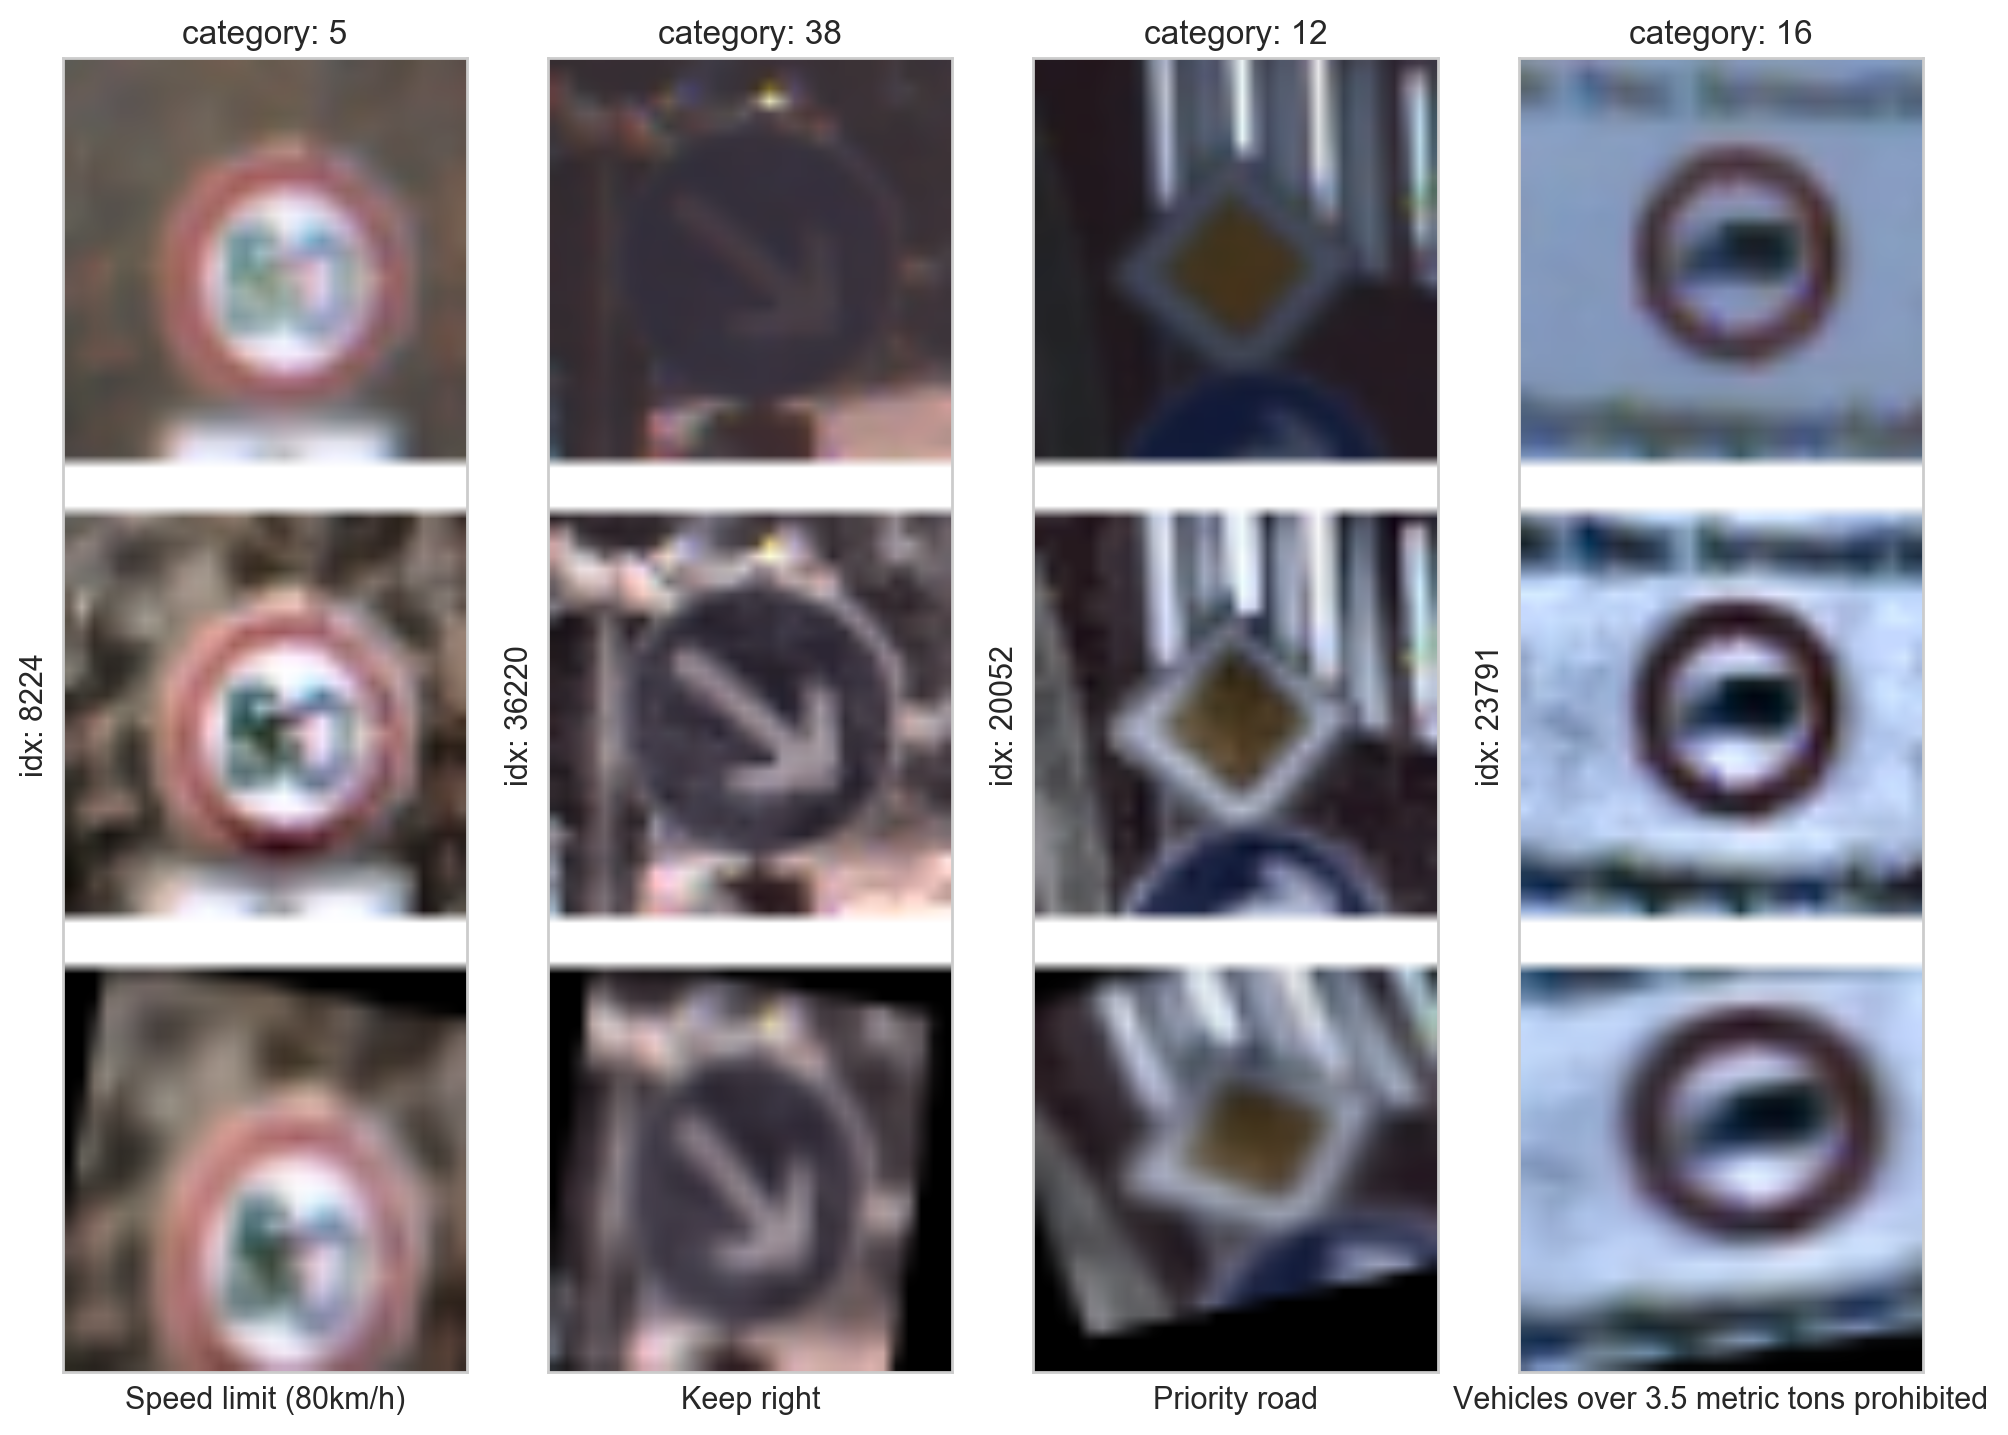

In [7]:
# visualize preprocessed and augmented images
# image standardization is only applied to batch image dataset
# the three rows correspond to the original, preprocessed and transformed

X_data = X_train
y_data = y_train

num_indices = 4
indices = np.random.randint(0, len(X_data), size=(num_indices))

plt.figure(figsize=(12,9))
for plot_idx, idx in enumerate(indices):
    img = X_data[idx].squeeze()
    img_proc = preprocess_single(img)
    img_aug = augment_image_single(img_proc).squeeze()
    img_div = 255*np.ones((4,32,3),dtype="uint8")
    
    plt.subplot(1,num_indices,plot_idx+1)
    plt.imshow(np.vstack([img, img_div, img_proc, img_div, img_aug]))
 
    plt.title("category: {}".format(y_data[idx]))
    plt.xlabel("{}".format(df_csv.SignName[y_data[idx]]))
    plt.ylabel("idx: {}".format(idx))
    plt.tick_params(labelbottom='off', labelleft='off')

plt.savefig("./figs/fig1.png")

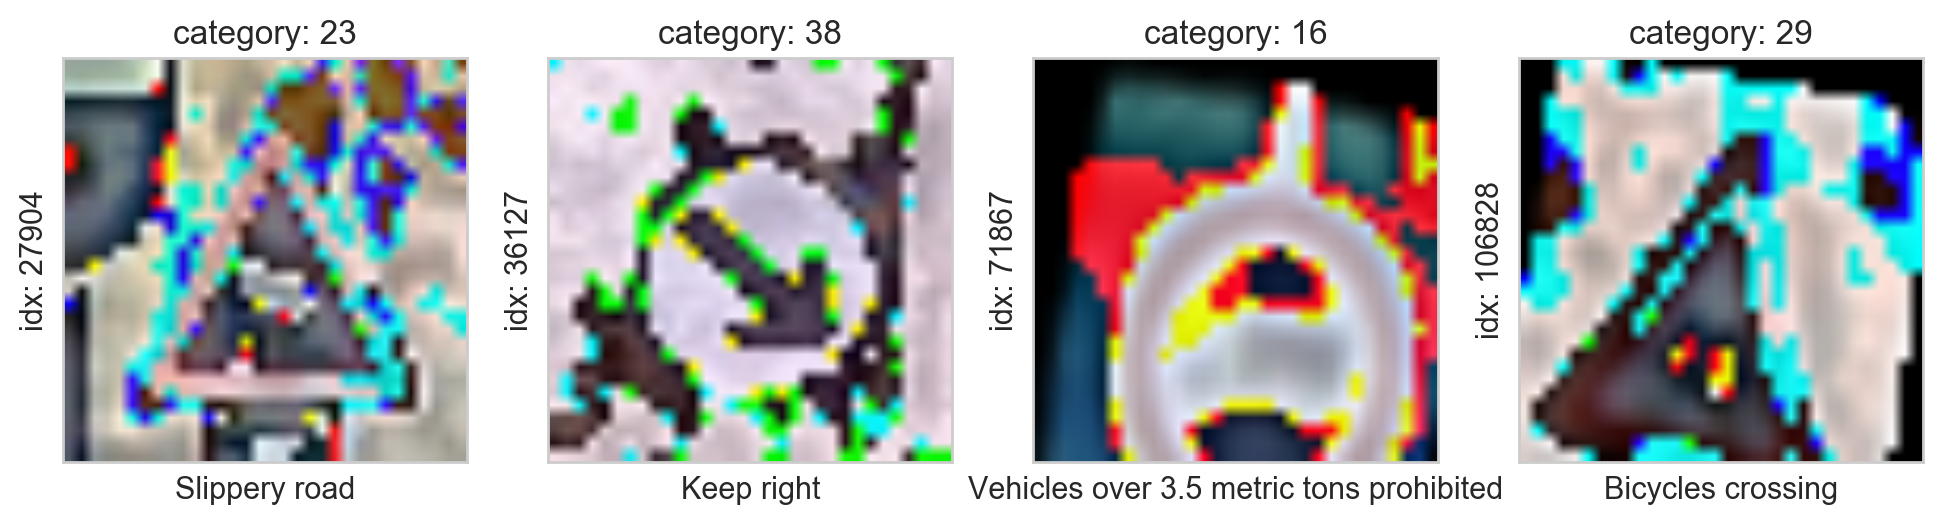

In [8]:
# visualize standardized and transformed images

X_data = X_train_augs
y_data = y_train_augs

num_indices = 4
indices = np.random.randint(0, len(X_data), size=(num_indices))

plt.figure(figsize=(12,9))
for plot_idx, idx in enumerate(indices):
    img = X_data[idx].squeeze()
    
    plt.subplot(1,num_indices,plot_idx+1)
    plt.imshow(img)
 
    plt.title("category: {}".format(y_data[idx]))
    plt.xlabel("{}".format(df_csv.SignName[y_data[idx]]))
    plt.ylabel("idx: {}".format(idx))
    plt.tick_params(labelbottom='off', labelleft='off')

----

## Step 3: Model Architecture Design and Training

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
import tensorflow as tf
import keras
import keras.backend as K
from keras.utils import visualize_util
from keras.layers import Activation, AveragePooling2D, BatchNormalization, Convolution2D, Dense, Dropout
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

K.set_learning_phase(1)

def traffic_sign_clf(x, dropout_p=0.5, mu = 0, sigma = 0.1):    

    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x32.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 32), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(32))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1   = BatchNormalization()(conv1)
    conv1   = tf.nn.relu(conv1)

    # Layer 2: Convolutional. Output = 24x24x64 -> Pooling = 12x12x64.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2   = BatchNormalization()(conv2)
    conv2   = tf.nn.relu(conv2)
    conv2   = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 3: Output = 8x8x160
    conv3 = Convolution2D(160,5,5, border_mode="valid", dim_ordering="tf")(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation(activation="relu")(conv3)
    
    # Layer 4: Output = 6x6x400 -> Pooling = 1x1x400 -> Flatten = 400
    conv4 = Convolution2D(400,3,3, border_mode="valid", dim_ordering="tf")(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation(activation="relu")(conv4)
    conv4 = AveragePooling2D(pool_size=(6,6), dim_ordering="tf")(conv4)

    fc0 = flatten(conv4)
    fc0 = Dropout(p=dropout_p)(fc0)
    
    # Layer 5 Fully Connected. Input = 400. Output = 43
    fc1_W  = tf.Variable(tf.truncated_normal(shape=(400, 43), mean = mu, stddev = sigma))
    fc1_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc0, fc1_W) + fc1_b
    logits = BatchNormalization()(logits)
    
    return logits

def run_ops(sess, X_data, y_data, ops=[]):
    '''Evaluate operations and return a list of results
    
    Implemented operations:
    ops=[op_accs, op_preds, op_labels, op_logits, op_preds_probs, op_training]
    
    '''
    
    # initialization
    num_samples = len(X_data)
    dict_ops = {op: idx for idx, op in enumerate(ops)}
        
    accs_total = 0
    results, preds, labels, logits, preds_probs, top_ks, losses = ([] for i in range(7))
    
    # evaluate operators
    for step, offset in enumerate(range(0, num_samples, BATCH_SIZE)):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        
        batch_results    = sess.run(ops, feed_dict={op_X: batch_x, op_y: batch_y})        
        
        for op in ops:
            batch_results_op = batch_results[dict_ops[op]]
            
            if op == op_accs:
                accs_total += (batch_results_op * len(batch_x))
            
            elif op == op_preds:
                preds.append(batch_results_op)
            
            elif op == op_labels:
                labels.append(batch_results_op)
            
            elif op == op_logits:
                logits.append(batch_results_op)

            elif op == op_preds_probs:
                preds_probs.append(batch_results_op)
                
            elif op == op_top_ks:
                top_ks.append([batch_results_op.indices, batch_results_op.values])
            
            elif op == op_loss:
                losses.append(batch_results_op)
                
            elif op == op_training:
                pass
            
            else:
                raise NotImplementedError
                break        
    
    # build a list of results to return
    for op in ops:        
        if op == op_accs:
            acc = accs_total / num_samples
            results.append(acc)
            
        elif op == op_preds:
            results.append(np.hstack(preds))

        elif op == op_labels:
            results.append(np.hstack(labels))

        elif op == op_logits:
            results.append(np.vstack(logits))
            
        elif op == op_preds_probs:
            results.append(np.vstack(preds_probs))
            
        elif op == op_top_ks:
            results.append(np.hstack(top_ks))
        
        elif op == op_loss:
            results.append(np.sum(losses)*len(batch_x)/num_samples)
            
        elif op == op_training:
            pass
            
    return results

In [9]:
# parameters
MODEL_NAME  = "traffic_sign_clf"
TRAIN_MODEL = False

EPOCHS      = 50
BATCH_SIZE  = 64

L_RATE      = 3e-4
L_DECAY     = 0.97
L_MOMENTUM  = 0.5
DROPOUT_P   = 0.5
MU          = 0
SIGMA       = 0.1
TOP_K       = 3

# variables with "op_" prefix belongs to the tf graph
# inputs 
op_X             = tf.placeholder(tf.float32, (None, 32, 32, 3))
op_y             = tf.placeholder(tf.int32,   (None))
op_y_ohe         = tf.one_hot(op_y, 43)

# operators
op_logits        = traffic_sign_clf(op_X, dropout_p=DROPOUT_P, mu=MU, sigma=SIGMA)
op_preds         = tf.argmax(op_logits, 1)
op_labels        = tf.argmax(op_y_ohe, 1)
op_preds_probs   = tf.nn.softmax(op_logits)
op_top_ks        = tf.nn.top_k(op_preds_probs, k=TOP_K)

op_preds_correct = tf.equal(op_preds, op_labels)
op_accs          = tf.reduce_mean(tf.cast(op_preds_correct, tf.float32))

# operators - training
op_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(op_logits, op_y_ohe)
op_loss          = tf.reduce_mean(op_cross_entropy)

op_optimizer     = tf.train.RMSPropOptimizer(learning_rate = L_RATE, decay=L_DECAY, momentum=L_MOMENTUM)
op_training      = op_optimizer.minimize(op_loss)

# initialization
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

Using TensorFlow backend.


In [10]:
if TRAIN_MODEL:
    val_accs = []
    val_losses = []

    train_accs = []
    train_losses = []

    print("Training...\n")
    for i in range(EPOCHS):

        # model training     
        K.set_learning_phase(1)
        X_train_std, y_train_std = shuffle(X_train_std, y_train_std)
        train_loss,train_acc, = run_ops(sess, X_train_std, y_train_std, ops=[op_loss, op_accs, op_training])

        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # model validation
        K.set_learning_phase(0)
        val_loss, val_acc = run_ops(sess, X_val_std, y_val_std, ops=[op_loss, op_accs])

        val_accs.append(val_acc)
        val_losses.append(val_loss)

        print("EPOCH {}/{} ...".format(i+1, EPOCHS))
        print("train_loss = {:6f}    val_loss = {:6f}    train_acc = {:.4f}    val_acc = {:.4f}\n"
              .format(train_loss, val_loss, train_acc, val_acc))

        if i > 0 and val_acc > np.max(val_accs[:-1]):
            saver.save(sess, MODEL_NAME)
            print("Model saved\n")

Training...

EPOCH 1/50 ...
train_loss = 0.370673    val_loss = 0.040563    train_acc = 0.8523    val_acc = 0.9649

EPOCH 2/50 ...
train_loss = 0.082204    val_loss = 0.019218    train_acc = 0.9773    val_acc = 0.9817

Model saved

EPOCH 3/50 ...
train_loss = 0.039324    val_loss = 0.017247    train_acc = 0.9903    val_acc = 0.9799

EPOCH 4/50 ...
train_loss = 0.020923    val_loss = 0.006572    train_acc = 0.9951    val_acc = 0.9935

Model saved

EPOCH 5/50 ...
train_loss = 0.012666    val_loss = 0.004527    train_acc = 0.9968    val_acc = 0.9961

Model saved

EPOCH 6/50 ...
train_loss = 0.008325    val_loss = 0.003173    train_acc = 0.9980    val_acc = 0.9980

Model saved

EPOCH 7/50 ...
train_loss = 0.006246    val_loss = 0.002703    train_acc = 0.9985    val_acc = 0.9975

EPOCH 8/50 ...
train_loss = 0.004284    val_loss = 0.002486    train_acc = 0.9988    val_acc = 0.9971

EPOCH 9/50 ...
train_loss = 0.003481    val_loss = 0.001453    train_acc = 0.9990    val_acc = 0.9984

Model sa

----

## Step 4: Model Testing

In [11]:
# model testing
loader = tf.train.import_meta_graph(MODEL_NAME+'.meta')
loader.restore(sess, tf.train.latest_checkpoint('./'))

ops     = [op_loss, op_accs, op_preds, op_labels, op_logits, op_preds_probs, op_top_ks]
outputs = run_ops(sess, X_test_std, y_test_std, ops=ops)
test_loss, test_acc, test_preds, test_labels, test_logits, test_preds_probs, test_top_ks = outputs
print("Testing...\n")    
print("test_loss= {:.6f}    test_acc = {:.4f}\n".format(test_loss, test_acc))

Testing...

test_loss= 0.021774    test_acc = 0.9872



----

## Step 5: Test Error Analysis

   index  Predicted  True Class
0    114         23          30
1    163         27          25
2    265         32          12
3    309         18          38
4    430         30          11

   index Top 1, 2 and 3  True Class
0    114   [23, 20, 19]          30
1    309    [18, 2, 17]          38
2    430    [30, 24, 9]          11
3    550    [23, 8, 10]           4
4    682    [25, 40, 3]          35

Top 1 test accuracy: 98.72%
Top 3 test accuracy: 99.53%


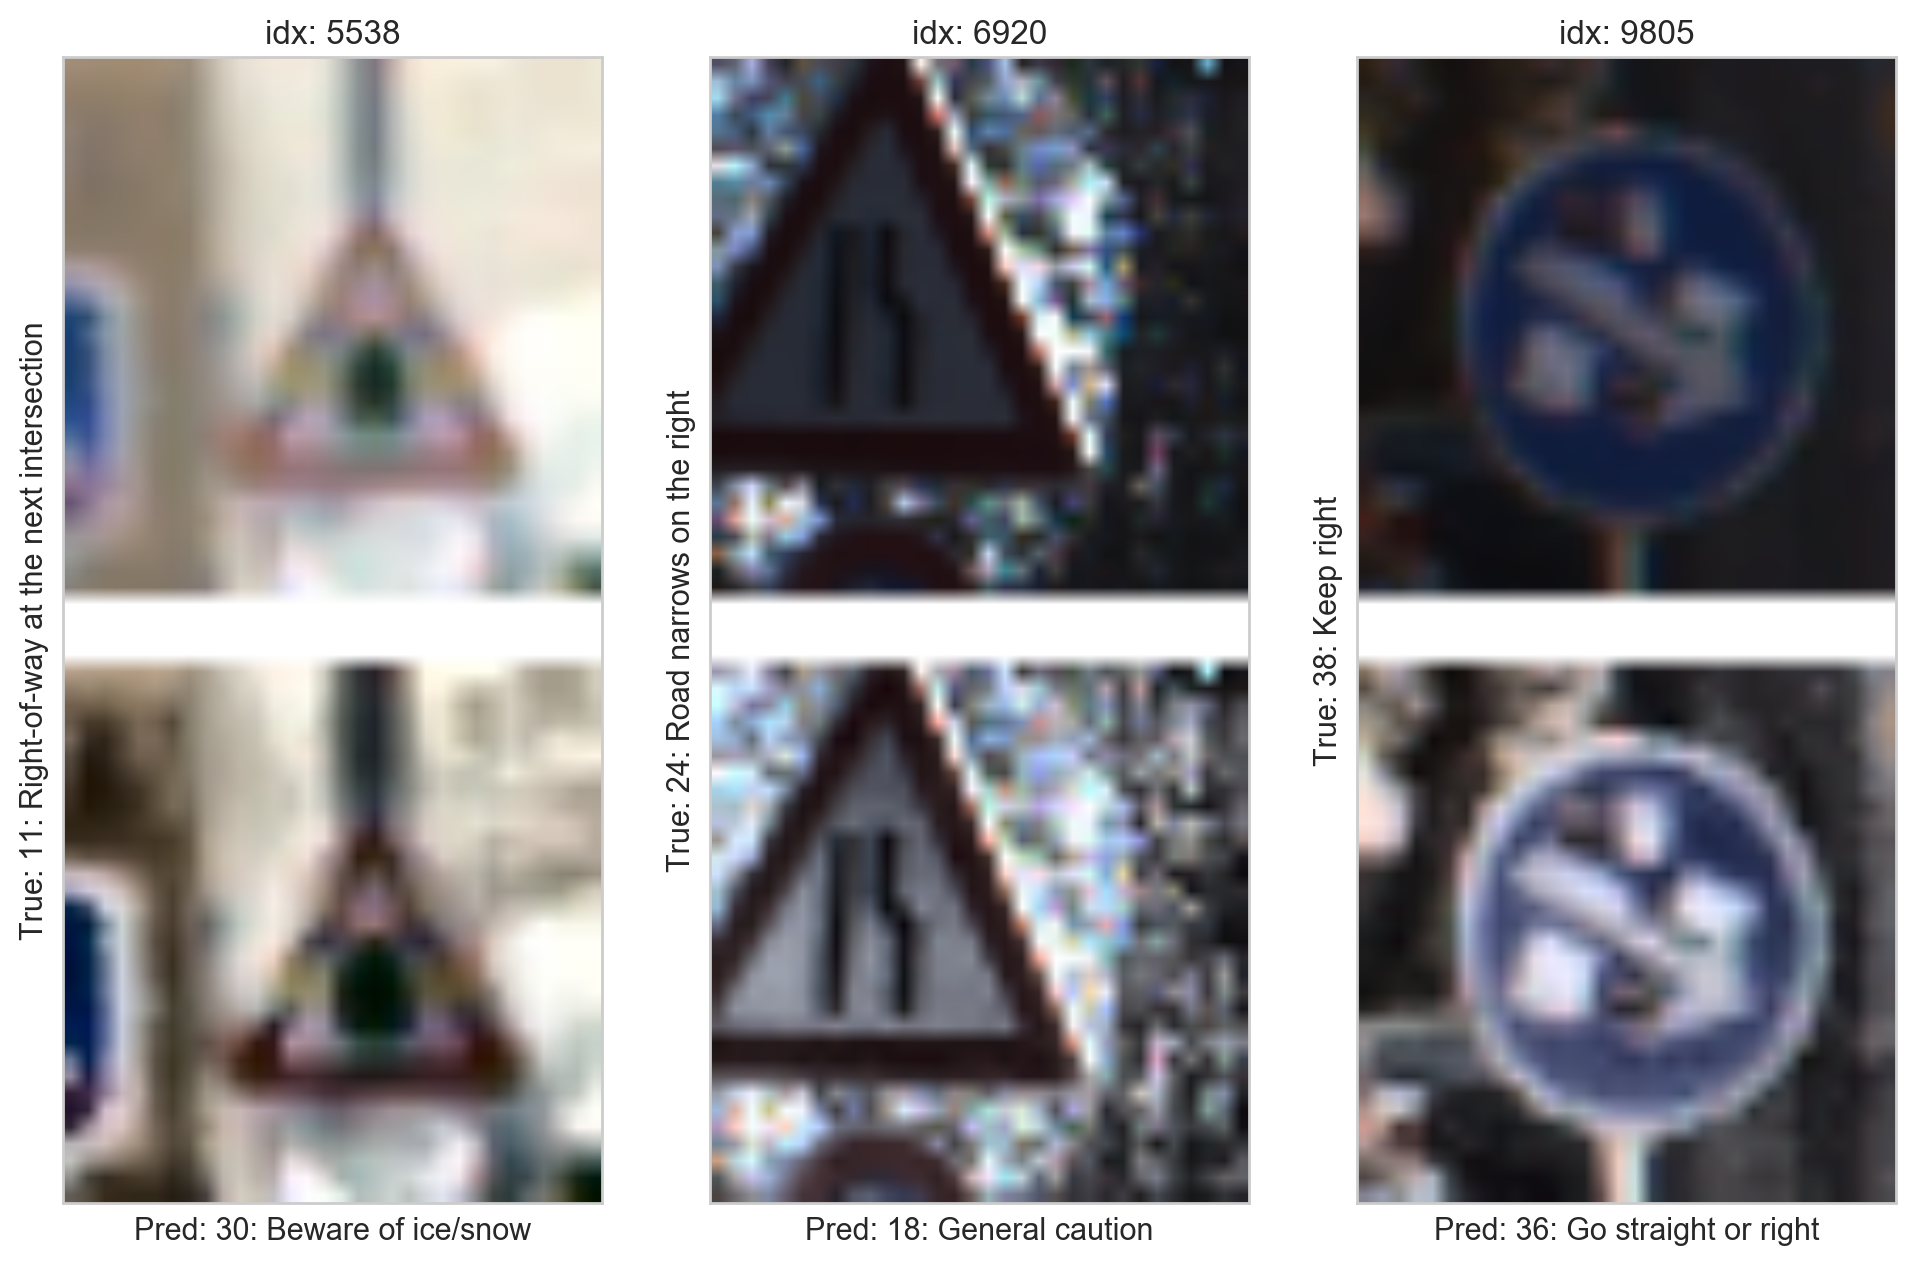

In [12]:
# analysis of prediction errors
test_errors = np.array([[idx, test_pred, test_label] for idx, (test_pred, test_label) 
                                                     in  enumerate(zip(test_preds, test_labels)) 
                                                     if  test_pred != test_label])

test_errors_top_ks = [[idx, np.array(test_top_k).astype('int'), test_label] for idx, (test_top_k, test_label) 
                                                     in  enumerate(zip(test_top_ks[0], test_labels)) 
                                                     if  test_label not in test_top_k]

# examples of prediction errors and top 3 errors
df_errors = pd.DataFrame(test_errors, columns=["index", "Predicted", "True Class"])
print(df_errors.head())
print()

df_errors_top_ks = pd.DataFrame(test_errors_top_ks, columns=["index", "Top 1, 2 and 3", "True Class"])
print(df_errors_top_ks.head())
print()

test_accuracy = 1-df_errors.shape[0]/len(y_test_std)
test_accuracy_top_k = 1-df_errors_top_ks.shape[0]/len(y_test_std)
print("Top 1 test accuracy: {:4.2f}%\nTop 3 test accuracy: {:4.2f}%".format(100*test_accuracy, 100*test_accuracy_top_k))

# visualize test prediction errors
# the two rows corresponds to the original and processed images respectively 
num_choice = 3
indices = np.random.choice(test_errors[:,0], size=num_choice)

test_labels = test_labels.astype("int")
test_preds = test_preds.astype("int")

plt.figure(figsize=(16,8))
for plot_idx, idx in enumerate(indices):
    idx = int(idx)
    img = X_test[idx].squeeze()
    img_proc = preprocess_single(img)
    img_div = 255*np.ones((4,32,3), dtype="uint8")
    
    plt.subplot(1,num_indices,plot_idx+1)
    plt.imshow(np.vstack([img, img_div, img_proc]))
    
    plt.ylabel("True: {}: {}".format(test_labels[idx], df_csv.SignName[test_labels[idx]]))
    plt.xlabel("Pred: {}: {}".format(test_preds [idx], df_csv.SignName[test_preds [idx]]))
    plt.title("idx: {}".format(idx))
    plt.tick_params(labelbottom='off', labelleft='off')

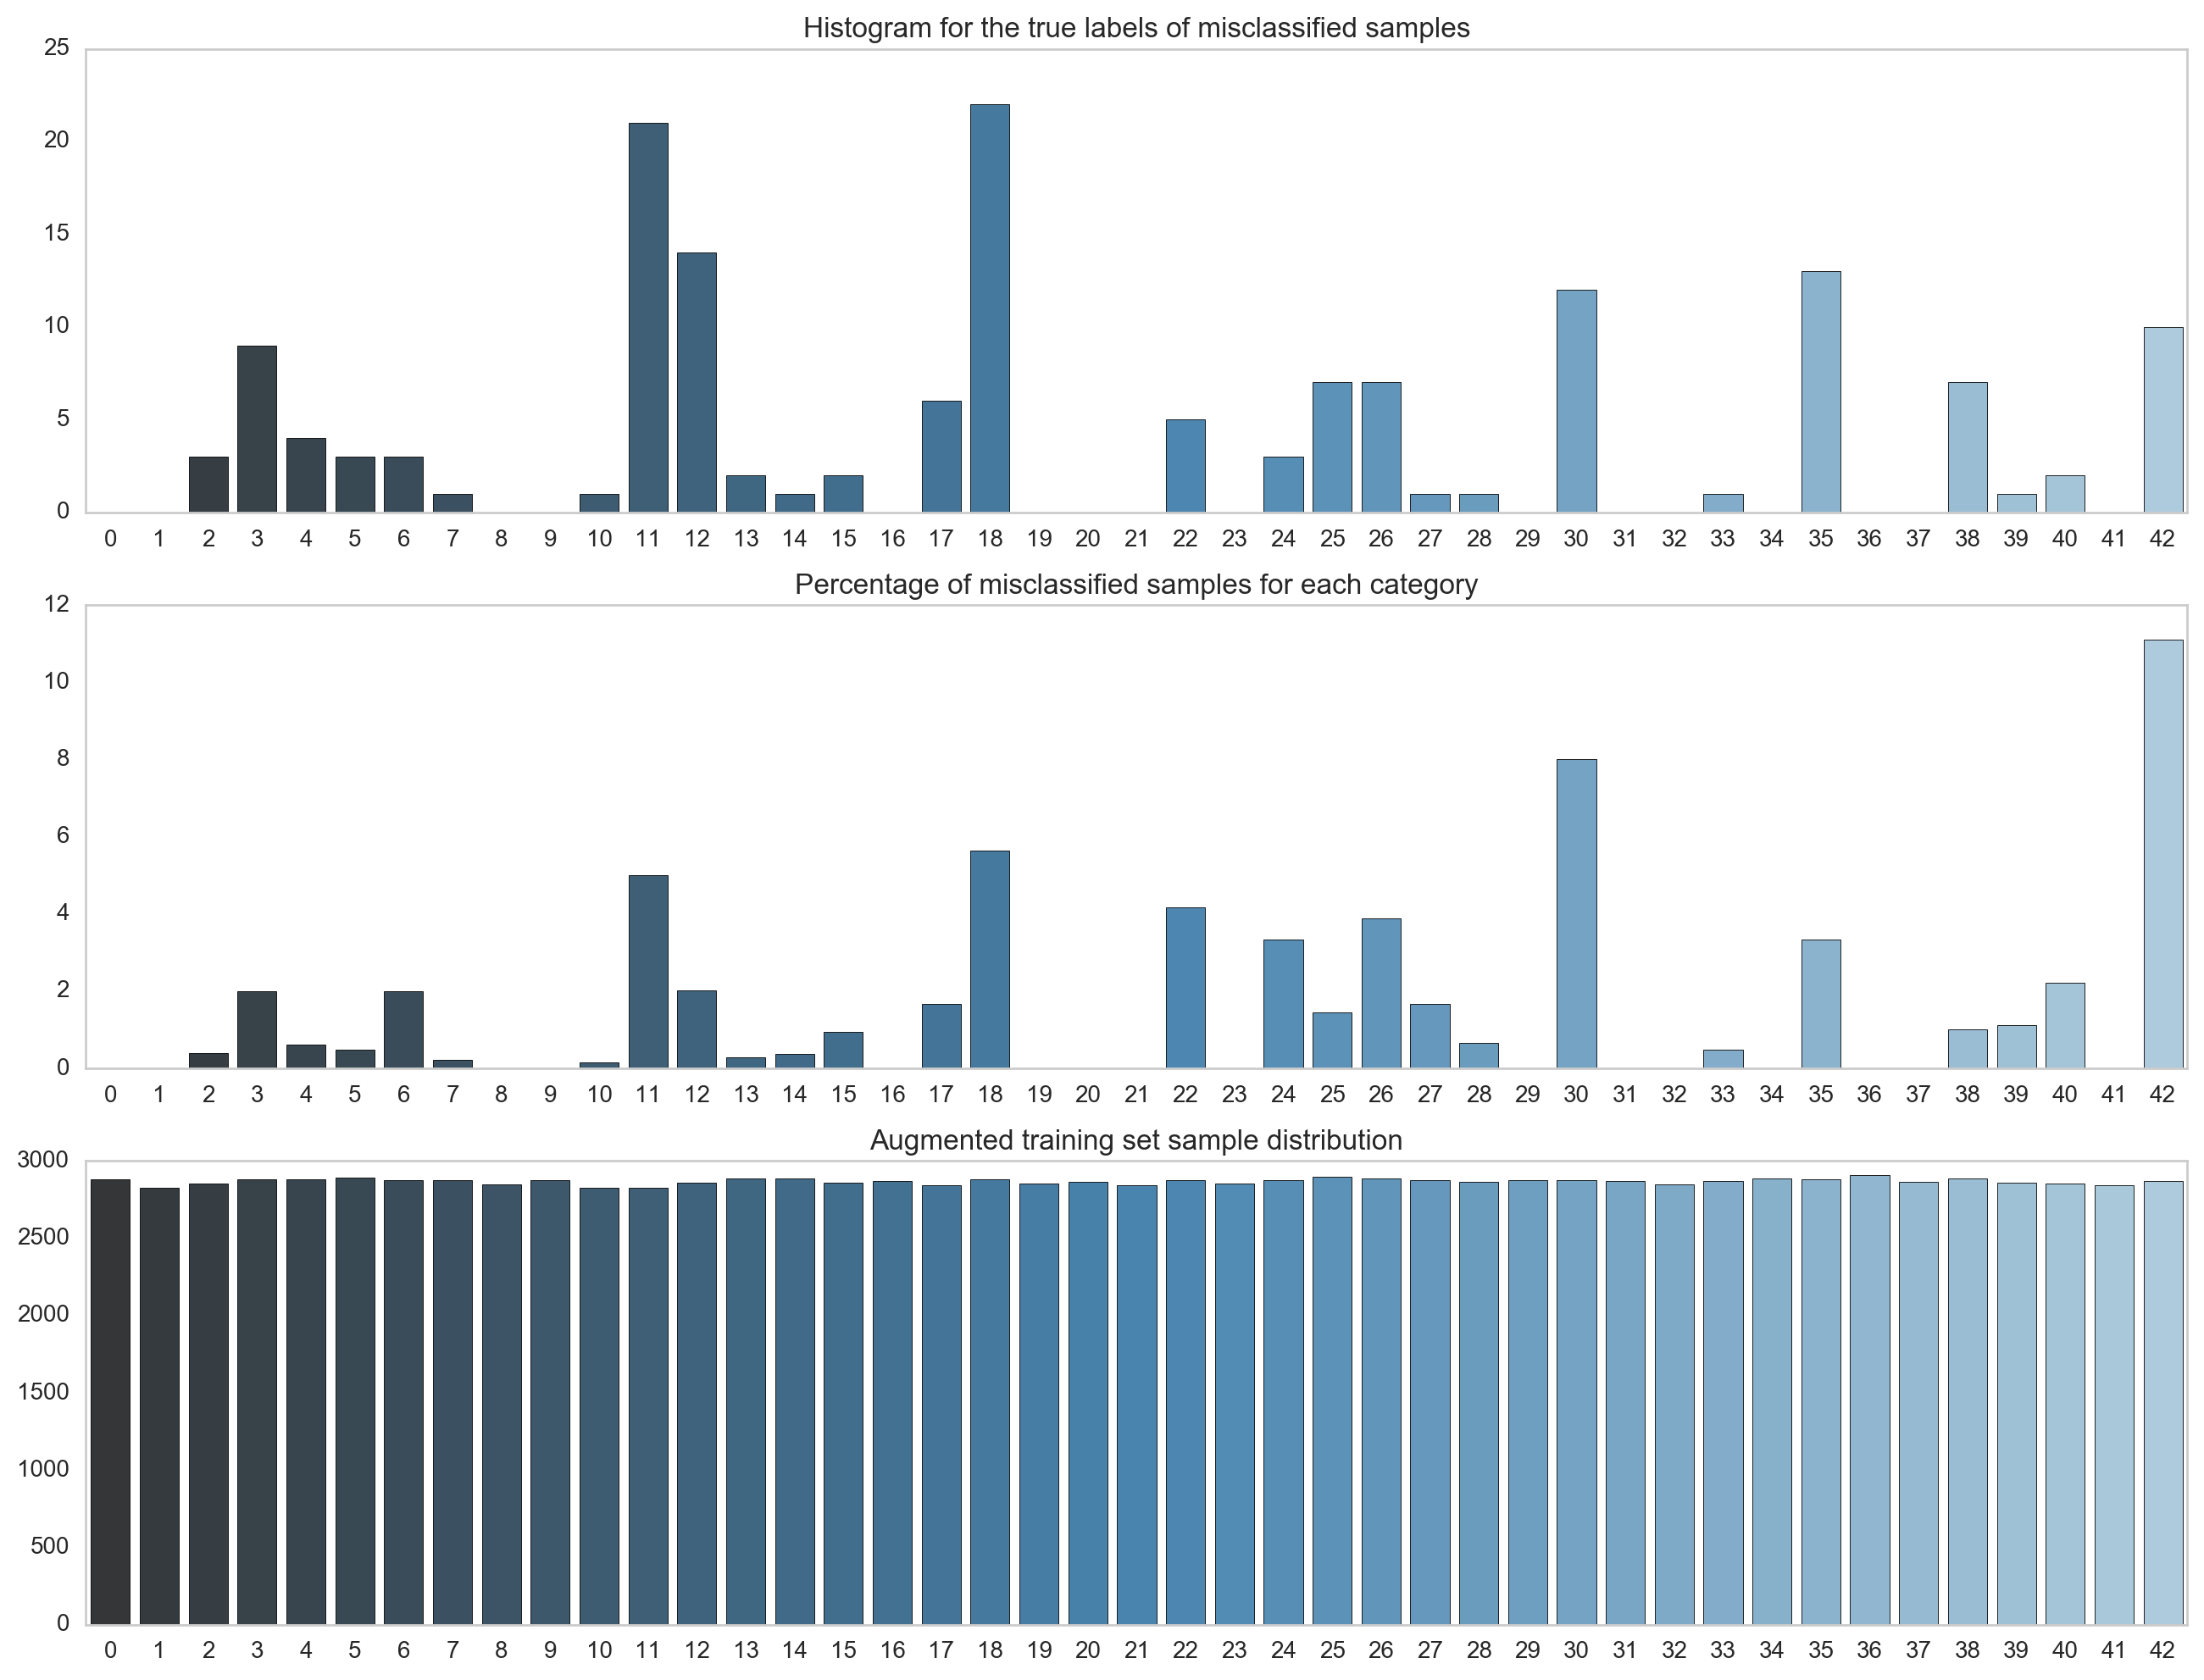

In [13]:
# distribution of test prediction errors
hist_bin            = np.arange(43+1)-0.5
hist_test_errors,_  = np.histogram(test_errors[:,2], bins=hist_bin)
hist_train_labels,_ = np.histogram(y_train_std, bins=hist_bin)
hist_test_labels,_  = np.histogram(y_test_std, bins=hist_bin)

hist_data_set       = [hist_test_errors, 100*hist_test_errors/hist_test_labels, hist_train_labels]

title_strs = ["Histogram for the true labels of misclassified samples", 
              "Percentage of misclassified samples for each category",
              "Augmented training set sample distribution"]

plt.figure(figsize=(16,12))
for idx, (hist_data, title_str) in enumerate(zip(hist_data_set, title_strs)):
    plt.subplot(3,1,idx+1)
    plt.title(title_str)
    sns.barplot(np.arange(43), hist_data , palette="Blues_d")


In [14]:
# sanity check
def my_softmax(x):
    '''Return probabilities given logits
    
    x is of the shape (num_of_samples, num_of_categories)
    '''
    exp_x = np.exp(x)   
    return (exp_x.T/np.sum(exp_x, axis=1)).T

def sanity_check():
    my_test_probs = my_softmax(test_logits)
    
    assert(test_acc - np.mean(np.equal(test_preds, test_labels)) < 1e-8)
    assert(np.mean(test_preds_probs - my_test_probs) < 1e-8)
    assert(np.mean(np.equal(np.argmax(test_logits,1), test_preds)) == 1)
    assert(np.mean(np.equal(y_test, test_labels)) == 1)
    
sanity_check()

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

For preprocessing, the image was first converted from RGB space to LAB space, followed by adaptive equalization of the L channel to mitigate variation in brightness levels. Then, the image would be converted back to RGB space to aid visualization. During batch preprocessing, the images were also standardized to zero mean, which could facilitate neural network weight updates. 

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

As shown in the histogram of the training set, some classes (eg: class 19) have 4-5 times less samples available for training compared to other classes (eg: class 2). To mitigate the impact of dataset imbalance, data augmentation was performed.

First, the target number of samples per class **(n_target)** was determined to be 3375, around 1.5 times the number of the most abundant class. Then **(n_aug = n_target - class_count)** samples were generated for each class to bring the number of samples per class to the same level. 

For each class, **n_aug** randomly chosen images underwent **translation**, **rotation** and **shearing** transformations before being appended back to the training image dataset. The labels for the newly generated images were simply copied from their untransformed counterparts.   

Finally, the augmented training dataset was split into a **training set (85%)** and a **validation set (15%)**.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The final model was constructed with a mixture of Tensorflow and Keras codes with 4 convolution layers and 1 fully connected layer. The output of this network were one-hot encoded logits. The specifications are as follows:

**layer 1**: input of (32,32,3) to output of (28,28,32). 2D convolution with filter shape of (5,5,3,32) followed by batch normalization and ReLu activation. 

**layer 2**: (28,28,32) to (24,24,64) to (12,12,64). 2D convolution with filter shape of (5,5,32,64) followed by batch normalization, ReLu activation and max pooling. 

**layer 3**: (12,12,64) to (8,8,160). Keras 2D convolution layer followed by batch normalization and ReLu activation. 

**layer 4**: (8,8,160) to (6,6,400) to (1,1,400) to (400). Keras 2D convolution layer followed by batch normalization, ReLu activation, average pooling and flatten operation. A dropout layer was also added here to help regularize the network.

**layer 5**: (400) to (43). Fully connected layer followed by batch normalization. 

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

RMSPropOptimizer was used for training the network with a learning rate of 3e-4, decay rate of 0.97 and momentum of 0.5. The total number of epoches and batch size were chosen to be 50 and 64 respectively. To prevent overfitting, a dropout probability of 0.5 was used. The parameters were largely tuned via trial and error. More sophisticated method such as randomized cross-validation could potentially used as well. 

The model with the best validation accuracy was selected as the final model for use against the testing set. Under the current hyperparameter settings, the **test accuracy** was found to be around **98.7%** with **top-3 accuracy** approaching **99.53%**.

As shown in the histogram for misclassfied samples (cell[13]), the most misclassfied categories were (class 11: right-of-way at the next intersection) and (class 18: general caution).

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

The original LeNet has only two conv layers, which might result in a representational bottleneck and thus limited model capacity. Following the general guideline for neural network design [https://goo.gl/PTCRij], I decided to increase the number of conv layers to 4 and only use dropout for regularization. The depth of each layer was usually expanded before applying pooling operations. During preliminary testing, relatively good performance can already be achived with the current network (test accuracy > 97%). As a result, I didn't spend too much additional effort tweaking the network architecture. 

---

## Step 6: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

In [137]:
### Load the images and plot them here.
import matplotlib.image as mpimg
from scipy.misc import imresize
import os

img_dir = "test_images/"
img_files = [img_dir + img_file for img_file in sorted(os.listdir(img_dir)) if img_file.endswith('.jpg')]

X_test_new = np.vstack([ np.array(imresize(mpimg.imread(img_file),(32,32,3))).reshape(1,32,32,3).astype('uint8')
               for img_file in img_files])
y_test_new = [14, 12, 2, 23, 13, 28]

X_test_std_new, y_test_std_new = preprocess_batch(X_test_new, y_test_new)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

Six images containing local or German traffic signs were chosen using Google images, which were subsequently resized to (32,32,3) in order to match the network input size. As shown in the figure below, it might be difficult to classify **the first image** as a "STOP" sign due to the presence of multiple signs. **The last image** would be guaranteed to produce a wrong classification result since it's not in the training set distribution. The **label 28** was chosen for the last image because of some similarities with the "children crossing" sign in the German traffic sign dataset. **The rest 4 images** have pretty clear markings and are expected to be classified correctly. 

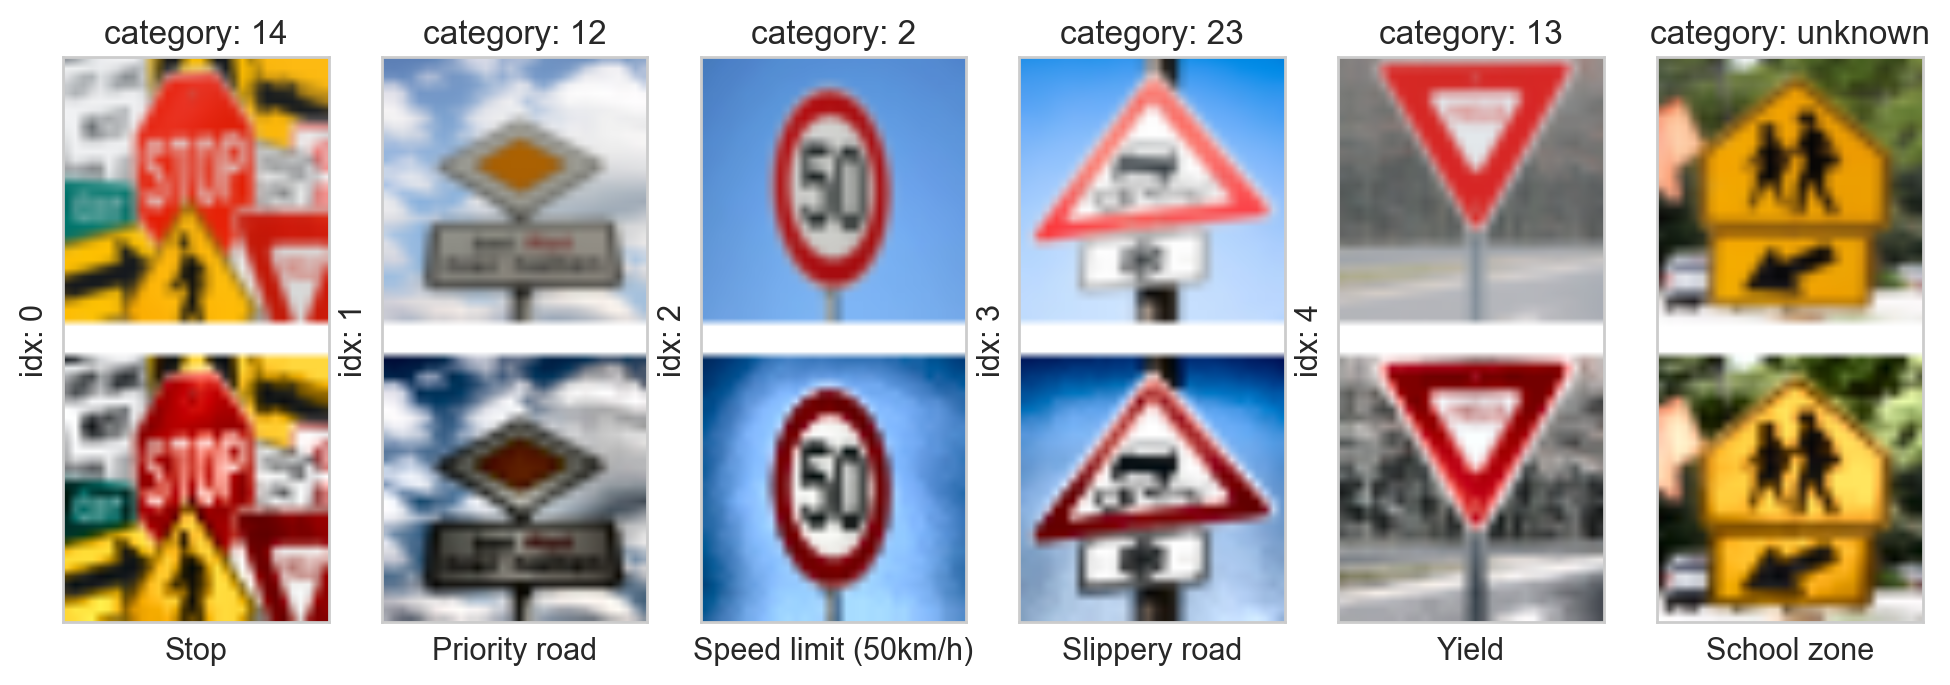

In [138]:
# visualize preprocessed and augmented images
# image standardization is only applied to batch image dataset
# the two rows correspond to the original and preprocessed images respectively 

num_indices = 6
indices = np.arange(0, len(X_test_new))

X_data = X_test_new
y_data = y_test_new

plt.figure(figsize=(12,9))
for plot_idx, idx in enumerate(indices):
    img = X_data[idx].squeeze()
    img_proc = preprocess_single(img)
    img_div = 255*np.ones((4,32,3),dtype="uint8")
    
    plt.subplot(1,num_indices,plot_idx+1)
    plt.imshow(np.vstack([img, img_div, img_proc]))
    
    if y_data[idx] != 28:
        plt.title("category: {}".format(y_data[idx]))
        plt.xlabel("{}".format(df_csv.SignName[y_data[idx]]))
        plt.ylabel("idx: {}".format(idx))
        plt.tick_params(labelbottom='off', labelleft='off')
    else:
        plt.title("category: {}".format("unknown"))
        plt.xlabel("School zone")
        plt.tick_params(labelbottom='off', labelleft='off')        

plt.savefig("./figs/fig2.png")

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

As expected, 5 out of the 6 images were classified correctly (the last image wrong). Incidentally, the top-3 accuracy didn't fare any better with the last image predicted to be "priority road", "speed limit (60km/h)" and "speed limit (80km/h)"

In [152]:
# evaluate the new test set

ops     = [op_loss, op_accs, op_preds, op_labels, op_logits, op_preds_probs, op_top_ks]
outputs = run_ops(sess, X_test_std_new, y_test_std_new, ops=ops)

test_loss, test_acc, test_preds, test_labels, test_logits, test_preds_probs, test_top_ks = outputs

print("Testing...\n")    
print("test_loss= {:.6f}    test_acc = {:.4f}\n".format(test_loss, test_acc))

Testing...

test_loss= 0.844572    test_acc = 0.8333



In [267]:
import matplotlib.patches as patches

def pred_error_analysis(X_data, y_data, test_preds, test_labels, test_top_ks, df_label_names,
                        print_text= True, save_fig=False):
    
    # analysis of prediction errors
    test_errors = np.array([[idx, test_pred, test_label] for idx, (test_pred, test_label) 
                                                         in  enumerate(zip(test_preds, test_labels)) 
                                                         if  test_pred != test_label])

    test_errors_top_ks = [[idx, np.array(test_top_k).astype('int'), test_label] for idx, (test_top_k, test_label) 
                                                         in  enumerate(zip(test_top_ks[0], test_labels)) 
                                                         if  test_label not in test_top_k]

    # examples of prediction errors and top k errors
    df_errors = pd.DataFrame(test_errors, columns=["index", "Predicted", "True Class"])
    df_errors_top_ks = pd.DataFrame(test_errors_top_ks, columns=["index", "Top 1, 2 and 3", "True Class"])
    
    if print_text == True:
        print(df_errors.head())
        print()
        print(df_errors_top_ks.head())
        print()

    test_accuracy = 1-df_errors.shape[0]/len(y_data)
    test_accuracy_top_k = 1-df_errors_top_ks.shape[0]/len(y_data)
    print("Top 1 test accuracy: {:4.2f}%\nTop 3 test accuracy: {:4.2f}%".format(100*test_accuracy, 
                                                                                100*test_accuracy_top_k))

    # visualize test prediction errors
    # the two rows corresponds to the original and processed images respectively 
   
    num_choice = 3
    indices = np.arange(len(y_data))
    # indices = np.random.choice(test_errors[:,0], size=num_choice)     

    test_labels = test_labels.astype("int")
    test_preds = test_preds.astype("int")
    
    
    plt.figure(figsize=(16,8))
    for plot_idx, idx in enumerate(indices):
        idx = int(idx)
        img = X_data[idx].squeeze()
        img_proc = preprocess_single(img)
        img_div = 255*np.ones((4,32,3), dtype="uint8")

        plt.subplot(1,num_indices,plot_idx+1)
        plt.imshow(np.vstack([img, img_div, img_proc]))

        plt.ylabel("True: {}: {}".format(test_labels[idx], df_label_names[test_labels[idx]]))
        plt.xlabel("Pred: {}: {}".format(test_preds [idx], df_label_names[test_preds [idx]]))
        plt.title("idx: {}".format(idx))
        plt.tick_params(labelbottom='off', labelleft='off')
    
    if save_fig == True:
        plt.savefig("./figs/pred_error_analysis.png")

def plot_top_ks(top_ks_dataset, save_fig=False):
    fig = plt.figure(figsize=(16,4))
     
    _, num_samples, k = top_ks_dataset.shape
    
    height  = 1/(k+2)
    dy      = 1/(k+1)
    d_alpha = 1/(k+2)
    
    # iterate over samples
    for idx_fig, (labels, probs) in enumerate(zip(*top_ks_dataset)):    
        ax = fig.add_subplot(1, num_samples, idx_fig+1, aspect='equal')
        
        # iterate over top k labels/probs within a sample
        for idx, (label, prob) in enumerate(zip(labels, probs)):
            
            x, y = 0, 1-dy*(idx+1)-height/2
            x_label, y_label = 0.075, 1-dy*(idx+1.1)
            width = prob
            alpha = 0.8-d_alpha*idx
            
            ax.add_patch(patches.Rectangle((x,y), width, height, alpha = alpha))
            ax.text(x_label, y_label, "Class: {:2} ({:4.2f}%)".format(int(label), 100*prob), 
                    weight="semibold", color='black', fontsize=10)
            
        plt.tick_params(labelbottom='off', labelleft='off')

    if save_fig == True:
        plt.savefig("./figs/plot_top_ks.png")

   index  Predicted  True Class
0      5          3          28

   index Top 1, 2 and 3  True Class
0      5     [3, 0, 27]          28

Top 1 test accuracy: 83.33%
Top 3 test accuracy: 83.33%


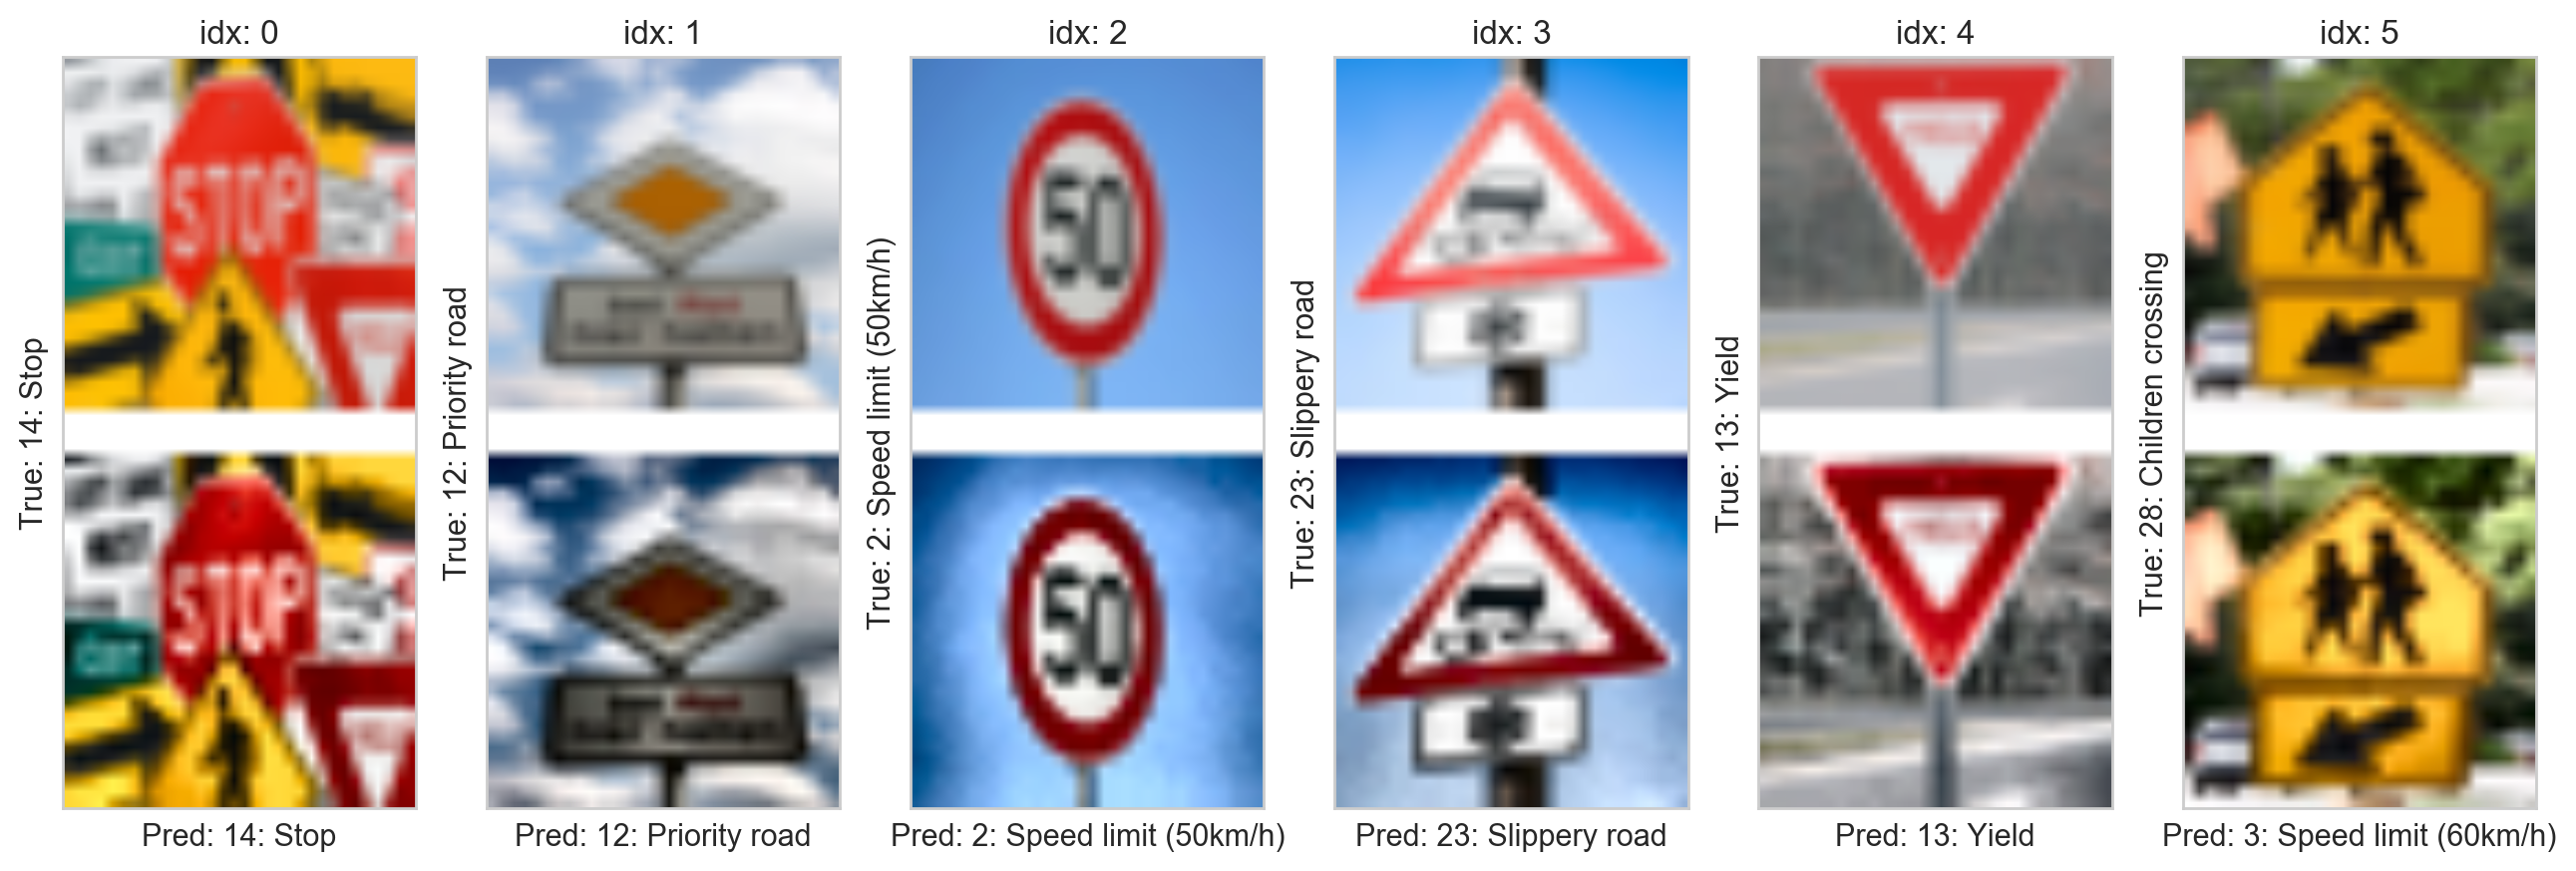

In [256]:
X_data         = X_test_new
y_data         = y_test_std_new
df_label_names = df_csv.SignName
        
pred_error_analysis(X_data, y_data, test_preds, test_labels, test_top_ks, df_label_names)
plot_top_ks(test_top_ks)

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

**Answer:**

As shown in the figure below (top-3 predictions for each test image), the trained model has greater than 60% confidence on the correctly classified images. As expected, the confidence for the unknown image category (image 6) is relatively low compared to other images. 

In conclusion, if trained on a dataset with more categories and examples, the model could potentially be used in more realistic situations such as performing real-time classifications on video feeds.

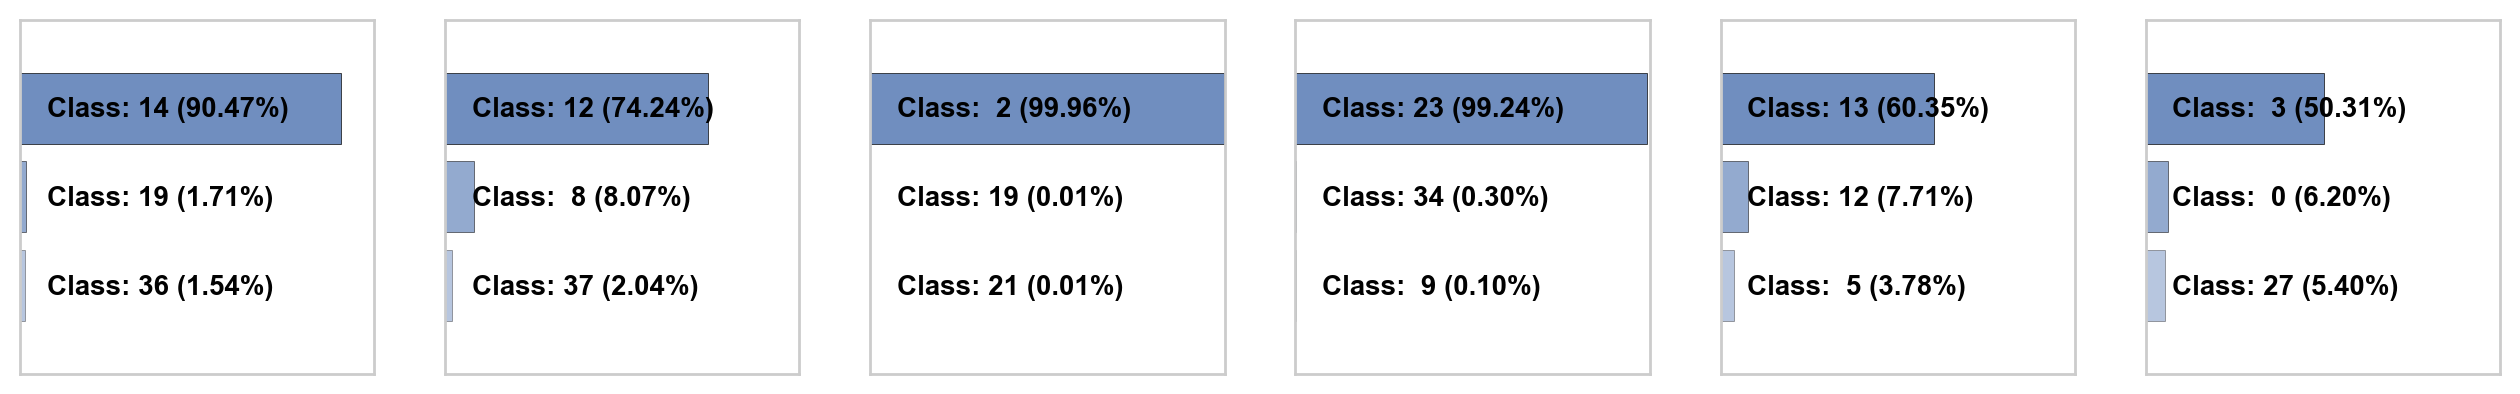

In [270]:
plot_top_ks(test_top_ks)

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.